In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import get_dummies
import math

## Preprocessing. Scaling

In [286]:
data = pd.read_csv("ExtraData.csv", sep=",")
data.drop(["Unnamed: 0", "X"], inplace=True, axis=1)
data.tail()

,sequence,length,meas,netmhc,netmhcpan,smmpmbec_cpp,molecular_weight,aromaticity,instability_index,isoelectric_point
2121,YVYPDNLPR,9,0.084693,0.120446,0.094057,0.280906,1136.2564,0.222222,18.866667,5.834900
2122,YVYPDNLPV,9,0.898488,0.765906,0.785698,0.708660,1079.2017,0.222222,48.644444,3.799866
2123,YWIREGKII,9,0.000000,0.080011,0.035959,0.086183,1177.3945,0.222222,-21.500000,8.589905
2124,YWMGGTTYF,9,0.350922,0.257071,0.220255,0.362626,1125.2518,0.444444,27.955556,5.523621
2125,YYFSYPLFV,9,0.550114,0.668012,0.656733,0.675035,1198.3636,0.555556,36.311111,5.522888


In [313]:
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(data[["molecular_weight","instability_index", "isoelectric_point"]])
x_scaled=pd.DataFrame(x_scaled, columns=["molecular_weight","instability_index", "isoelectric_point"])
x_scaled["aromaticity"]=data["aromaticity"]
x_scaled.tail()

,molecular_weight,instability_index,isoelectric_point,aromaticity
2121,0.548323,0.231246,0.266668,0.222222
2122,0.478572,0.335037,0.046140,0.222222
2123,0.598616,0.090546,0.565215,0.222222
2124,0.534869,0.262926,0.232936,0.444444
2125,0.624251,0.292049,0.232856,0.555556


In [34]:
#it was done in R
from math import log
def logmeas(i):
    val = np.linspace(1, np.log(i)/np.log(50000))
    return 1 - min(val)

In [84]:
from sklearn import preprocessing

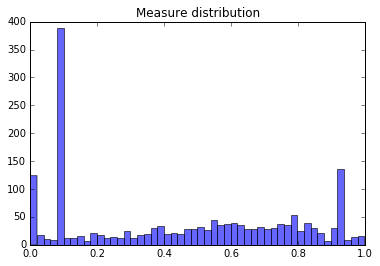

In [338]:
indexes = data['sequence'][data['length'] == 9].index
#indexes = data.index
selected_X = data["sequence"][indexes]


selected_y = pd.DataFrame(data['meas'][indexes])
selected_y['netmhc'] = pd.DataFrame(data['netmhc'][indexes])
selected_y['netmhcpan'] = pd.DataFrame(data['netmhcpan'][indexes])
selected_y['smmpmbec_cpp'] = pd.DataFrame(data['smmpmbec_cpp'][indexes])

plt.title("Measure distribution")
hh = plt.hist(selected_y['meas'], 50, color = 'blue', alpha = 0.6)

In [339]:
letters_X = selected_X.apply(list)
selected_X=pd.get_dummies(pd.DataFrame(list(letters_X)))

In [340]:
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(data[["molecular_weight","instability_index", "isoelectric_point"]])
x_scaled=pd.DataFrame(x_scaled, columns=["molecular_weight","instability_index", "isoelectric_point"])


In [343]:
selected_X["molecular_weight"] = pd.DataFrame(x_scaled["molecular_weight"][indexes]).reset_index(drop=True)
selected_X["instability_index"] = pd.DataFrame(x_scaled["instability_index"][indexes]).reset_index(drop=True)
selected_X["isoelectric_point"] = pd.DataFrame(x_scaled["isoelectric_point"][indexes]).reset_index(drop=True)
selected_X["aromaticity"] = pd.DataFrame(data["aromaticity"][indexes]).reset_index(drop=True)

## SVR

In [352]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error

In [353]:
random_number = 53
X_train, X_test, y_train, y_test = train_test_split(selected_X, selected_y["meas"],
                                                    test_size = 0.33, random_state = random_number)

test_index = y_test.index
mse_netmhc = mean_squared_error(selected_y["meas"], selected_y["netmhc"])
mse_netmhcpan = mean_squared_error(selected_y["meas"], selected_y["netmhcpan"])
mse_smmpmbec_cpp = mean_squared_error(selected_y["meas"], selected_y["smmpmbec_cpp"])

In [48]:
from sklearn.svm import SVR
from sklearn.grid_search import GridSearchCV
from sklearn.learning_curve import learning_curve
from sklearn.kernel_ridge import KernelRidge

In [345]:
svr = GridSearchCV(SVR(kernel='rbf', gamma=0.1), cv=5,
                   param_grid={"C": [1e-3, 1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)})

In [346]:
svr.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'gamma': array([  1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02]), 'C': [0.001, 1.0, 10.0, 100.0, 1000.0]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [91]:
svr.best_params_

{'C': 1.0, 'gamma': 0.10000000000000001}

In [347]:
TunedSVR = SVR(kernel='rbf', C=1, gamma=0.10000000000000001)

In [348]:
TunedSVR.fit(X_train, y_train)

SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [357]:
print("SVR MSE:", mean_squared_error(y_test,TunedSVR.predict(X_test)))
print("netmhc MSE:", mse_netmhc)
print("netmhcpan MSE:", mse_netmhcpan)
print("smmpmbec_cpp MSE:", mse_smmpmbec_cpp)

SVR MSE: 0.0380195603249
netmhc MSE: 0.0289021865583
netmhcpan MSE: 0.0289280856635
smmpmbec_cpp MSE: 0.0331315186522


## Kedera

In [ ]:
amino=pd.read_csv("acids.csv", sep=" ", index_col=False)
d = amino.to_dict(orient='list')
 
f = ['f1','f2','f3','f4','f5','f6','f7','f8','f9','f10']
 
def kidera(pept):
    global d
    seq = list(pept)
    dim = len(seq)
    kidera = [0]*10
    for i in range(10):
        kidera[i] = [0]*dim
       
    for k in range(dim):
        for i in range(20):
            if seq[k] == d['amino'][i]:
                for j in range(10):
                    kidera[j][k] = d[f[j]][i]
   
    for i in range(10):
        kidera[i] = sum(kidera[i])/len(kidera[i])
   
    return kidera
 
kidera('AARAALQGG')